# Streaming Data Analytics Project
We have used the neural network model from [here](https://www.hackster.io/manivannan/industry-4-0-predictive-maintenance-3bb415)
So, we have not used a neural network model from scratch. We have used the model from the above link and modified it to suit our needs.
We havent used a validation dataset for hyper-parameters tuning as we had already the best hyper-parameters from the above link.

In [92]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, Reshape, MaxPooling1D
from tensorflow.keras.optimizers import Adam

def importData(data_id):
    # import X and y data
    X = np.load('Data/id_' + data_id + '/X.npy')
    y = np.load('Data/id_' + data_id + '/y.npy')

    y = y[:, 0]

    y[y == 2] = 0
    return X, y

def splitAndBalance(X, y):
    # (train/validation) test split with balanced classes
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    training_anomalies = np.count_nonzero(y_train)
    test_anomalies = np.count_nonzero(y_test)

    print('Number of anomalies in training set: ', training_anomalies)

    # balance the classes in the training set
    X_train = np.concatenate((X_train[y_train == 1], X_train[y_train == 0][:training_anomalies]))
    y_train = np.concatenate((y_train[y_train == 1], y_train[y_train == 0][:training_anomalies]))

    # balance the classes in the test set
    X_test = np.concatenate((X_test[y_test == 1], X_test[y_test == 0][:test_anomalies]))
    y_test = np.concatenate((y_test[y_test == 1], y_test[y_test == 0][:test_anomalies]))

    # shuffle the training set
    shuffle_index = np.random.permutation(len(X_train))
    X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

    # shuffle the test set
    shuffle_index = np.random.permutation(len(X_test))
    X_test, y_test = X_test[shuffle_index], y_test[shuffle_index]

    return X_train, X_test, y_train, y_test


def buildModel(X_train):
    LEARNING_RATE = 0.005

    input_length = X_train.shape[1]
    classes = 1

    # model architecture
    model = Sequential()
    model.add(Reshape((int(input_length / 40), 40)))
    model.add(Conv1D(8, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
    model.add(Dropout(0.25))
    model.add(Conv1D(16, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(20, activation='relu',
        activity_regularizer=tf.keras.regularizers.l1(0.00001)))
    model.add(Dense(10, activation='relu',
        activity_regularizer=tf.keras.regularizers.l1(0.00001)))
    model.add(Dense(classes, name='y_pred', activation='sigmoid'))

    # this controls the learning rate
    opt = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999)

    # train the neural network
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

data = dict()

for id in ['00', '02', '04', '06']:
    EPOCHS = 100

    # import data
    X, y = importData(id)

    # split and balance the data
    X_train, X_test, y_train, y_test = splitAndBalance(X, y)

    data[id] = (X_train, X_test, y_train, y_test)

    # build the model
    model = buildModel(X_train)

    model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.2, shuffle=True, verbose=2)

    # save the model with the id
    model.save('Models/model_' + id + '.h5')


Number of anomalies in training set:  1021
Number of anomalies in training set:  815
Number of anomalies in training set:  714
Number of anomalies in training set:  744


2023-05-11 10:43:39.880015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 0s 21ms/step - loss: 2.2196 - accuracy: 0.6034


2023-05-11 10:43:41.240888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 0s 16ms/step - loss: 5.1925 - accuracy: 0.7270


2023-05-11 10:43:42.595897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 0s 19ms/step - loss: 1.8896 - accuracy: 0.6983


2023-05-11 10:43:43.920708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 0s 17ms/step - loss: 0.2054 - accuracy: 0.9598


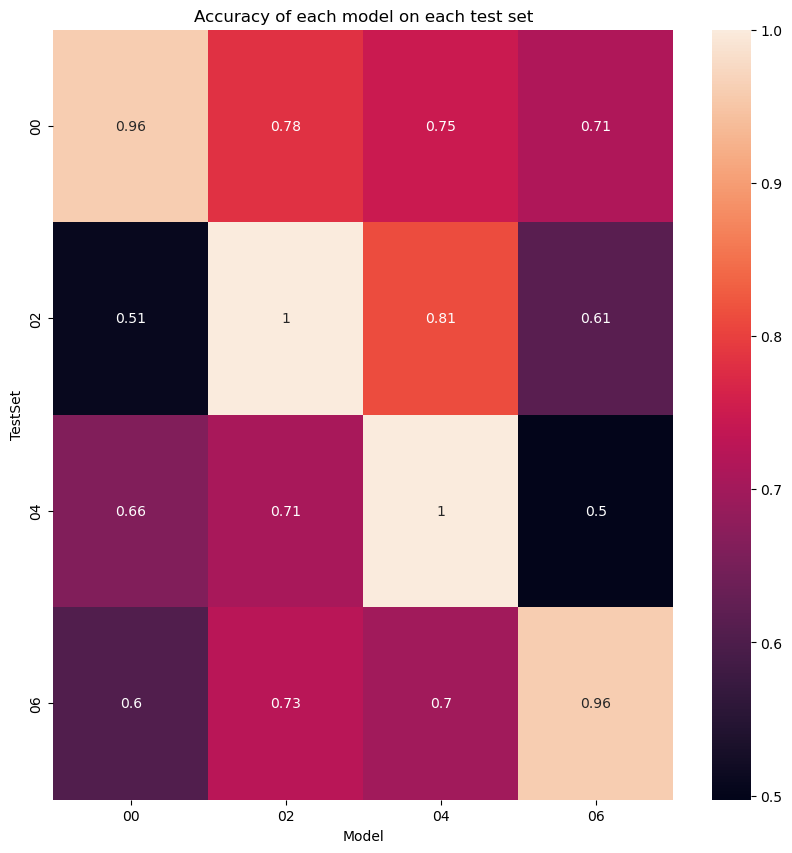

In [97]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf

accuracies = dict()

# evaluate each model on all the test sets
for model_id in ['00', '02', '04', '06']:
    model = tf.keras.models.load_model('Models/model_' + model_id + '.h5')

    accuracies[model_id] = dict()

    for test_id in ['00', '02', '04', '06']:
        X_train, X_test, y_train, y_test = data[test_id]

        # evaluate the model
        loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
        accuracies[model_id][test_id] = accuracy

# plot all the accuracies with 4 floating points
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(pd.DataFrame(accuracies), annot=True, ax=ax)
ax.set_title('Accuracy of each model on each test set')
ax.set_xlabel('Model')
ax.set_ylabel('TestSet')
plt.show()

In [98]:
# Try to train a model on all the data
X_train = np.concatenate((data['00'][0], data['02'][0], data['04'][0], data['06'][0]))
y_train = np.concatenate((data['00'][2], data['02'][2], data['04'][2], data['06'][2]))

X_test = np.concatenate((data['00'][1], data['02'][1], data['04'][1], data['06'][1]))
y_test = np.concatenate((data['00'][3], data['02'][3], data['04'][3], data['06'][3]))

model = buildModel(X_train)

model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.2, shuffle=True, verbose=2)

model.save('Models/model_all.h5')

Epoch 1/100


2023-05-11 10:43:55.526765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-11 10:43:58.452532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


165/165 - 5s - loss: 0.3145 - accuracy: 0.8397 - val_loss: 0.3879 - val_accuracy: 0.7929 - 5s/epoch - 30ms/step
Epoch 2/100
165/165 - 2s - loss: 0.1965 - accuracy: 0.9402 - val_loss: 0.3679 - val_accuracy: 0.8338 - 2s/epoch - 12ms/step
Epoch 3/100
165/165 - 2s - loss: 0.1811 - accuracy: 0.9406 - val_loss: 0.3869 - val_accuracy: 0.8194 - 2s/epoch - 11ms/step
Epoch 4/100
165/165 - 2s - loss: 0.1367 - accuracy: 0.9571 - val_loss: 0.4466 - val_accuracy: 0.7815 - 2s/epoch - 11ms/step
Epoch 5/100
165/165 - 2s - loss: 0.1053 - accuracy: 0.9668 - val_loss: 0.5630 - val_accuracy: 0.7951 - 2s/epoch - 11ms/step
Epoch 6/100
165/165 - 2s - loss: 0.0952 - accuracy: 0.9694 - val_loss: 0.6101 - val_accuracy: 0.7898 - 2s/epoch - 11ms/step
Epoch 7/100
165/165 - 2s - loss: 0.0865 - accuracy: 0.9710 - val_loss: 0.6907 - val_accuracy: 0.7906 - 2s/epoch - 11ms/step
Epoch 8/100
165/165 - 2s - loss: 0.0771 - accuracy: 0.9753 - val_loss: 0.6561 - val_accuracy: 0.8042 - 2s/epoch - 11ms/step
Epoch 9/100
165/165 

2023-04-25 11:39:45.887720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


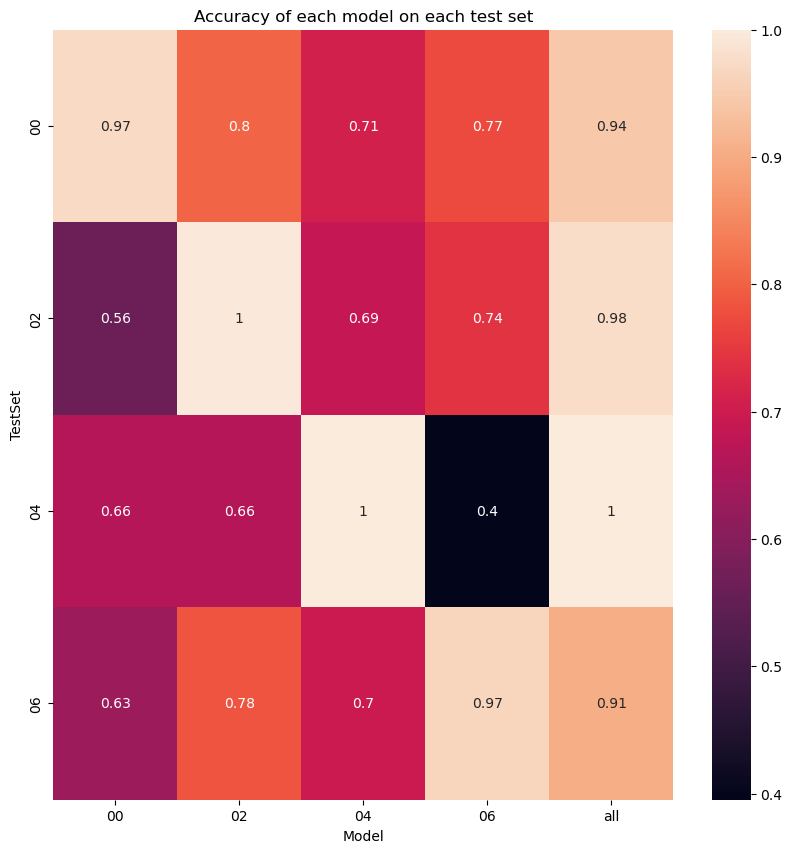

In [4]:
# evaluate the model on each test set

model = tf.keras.models.load_model('Models/model_all.h5')
accuracies['all'] = dict()

for test_id in ['00', '02', '04', '06']:
    X_train, X_test, y_train, y_test = data[test_id]

    # evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    accuracies['all'][test_id] = accuracy

# plot all the accuracies
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(pd.DataFrame(accuracies), annot=True, ax=ax)
ax.set_title('Accuracy of each model on each test set')
ax.set_xlabel('Model')
ax.set_ylabel('TestSet')
plt.show()


# Transfer learning
Using transfer learning we have tried to extract data from the inner layers of the pre-trained Neural Network.
We have used HalfSpaceTrees as the streaming anomaly detection algorithm.
We have divided the dataset in train/validation/test sets with a 80/10/10 ratio.

## Metrics
Precision, Recall and F1-score are been used as metrics for the evaluation of the model.

$$Precision = \frac{TP}{TP+FP}$$
$$Recall = \frac{TP}{TP+FN}$$
$$F1-score = 2\frac{Precision*Recall}{Precision+Recall}$$

After the training, we have used the validation set to find the best threshold for the anomaly detection algorithm. We have used the F1-score as the metric for the threshold selection.
Then, we have evaluated the model on the test set.

In [84]:
# check all the roc auc with the all model
# import train and test split
from sklearn.model_selection import train_test_split
import tensorflow as tf
from river import compose
from river import datasets
from river import metrics
from river import preprocessing
from river import anomaly
import matplotlib.pyplot as plt



all_rocauc = dict()
f1_score = {}
precision = {}
recall = {}

for id in ['00', '02', '04', '06']:
    nn_model = tf.keras.models.load_model('Models/model_' + id + '.h5')
    tf_learning_model = tf.keras.models.Sequential(nn_model.layers[:-1])

    model = compose.Pipeline(
        preprocessing.MinMaxScaler(),
        anomaly.HalfSpaceTrees(
            n_trees=150,
            window_size=15
        )
    )

    # import data
    X, y = importData(id)

    # split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, shuffle=True)

    # extract the features from the model
    X_trunk = tf_learning_model.predict(X_train, verbose=0)
    X_trunk_test = tf_learning_model.predict(X_test, verbose=0)
    X_trunk_val = tf_learning_model.predict(X_val, verbose=0)

    # startup of the HalfSpaceTrees model
    for index in range(0, X_trunk.shape[0]):
        model = model.learn_one({i: X_trunk[index, i] for i in range(X_trunk.shape[1])})

    score = []

    # validation of the model
    for index in range(0, X_trunk_val.shape[0]):
        model = model.learn_one({i: X_trunk_val[index, i] for i in range(X_trunk_val.shape[1])})
        score.append(model.score_one({i: X_trunk_val[index, i] for i in range(X_trunk_val.shape[1])}))
    
    score = np.array(score)
    
    # concatenate the score and the y_test
    check = np.concatenate((score.reshape(-1, 1), y_val.reshape(-1, 1)), axis=1)

    # valuate the precision of the model
    f1_score[id] = {}
    precision[id] = {}
    recall[id] = {}

    for threshold in np.arange(0, 1, 0.01):
        # calculate the f1_score, precision and recall
        TN = np.sum(check[check[:, 0] < threshold, 1] == 0)
        FP = np.sum(check[check[:, 0] >= threshold, 1] == 0)
        FN = np.sum(check[check[:, 0] < threshold, 1] == 1)
        TP = np.sum(check[check[:, 0] >= threshold, 1] == 1)

        f1_score[id][threshold] = 2 * TP / (2 * TP + FP + FN)
        precision[id][threshold] = TP / (TP + FP)
        recall[id][threshold] = TP / (TP + FN)

    # choose the threshold on the validation set
    max_threshold = max(f1_score[id], key=f1_score[id].get)

    score = []
    
    # test the model
    for index in range(0, X_trunk_test.shape[0]):
        model = model.learn_one({i: X_trunk_test[index, i] for i in range(X_trunk_test.shape[1])})
        score.append(model.score_one({i: X_trunk_test[index, i] for i in range(X_trunk_test.shape[1])}))

    score = np.array(score)
    check = np.concatenate((score.reshape(-1, 1), y_test.reshape(-1, 1)), axis=1)

    TN = np.sum(check[check[:, 0] < max_threshold, 1] == 0)
    FP = np.sum(check[check[:, 0] >= max_threshold, 1] == 0)
    FN = np.sum(check[check[:, 0] < max_threshold, 1] == 1)
    TP = np.sum(check[check[:, 0] >= max_threshold, 1] == 1)

    print(f'precision for {id} is {TP / (TP + FP)} and recall is {TP / (TP + FN)}')

2023-05-11 10:13:10.312482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/lorenzobenzoni/miniconda3/envs/tensorflow/lib/python3.10/site-packages/river/preprocessing/scale.py:30: RuntimeWarning: invalid value encountered in scalar divide
  return a / b if b else 0.0


precision for 00 is 0.47619047619047616 and recall is 0.5042016806722689


2023-05-11 10:13:37.605093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


precision for 02 is 0.8869565217391304 and recall is 0.9107142857142857


2023-05-11 10:14:03.942838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


precision for 04 is 0.8958333333333334 and recall is 0.9347826086956522


2023-05-11 10:14:23.175814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


precision for 06 is 0.96875 and recall is 0.2743362831858407


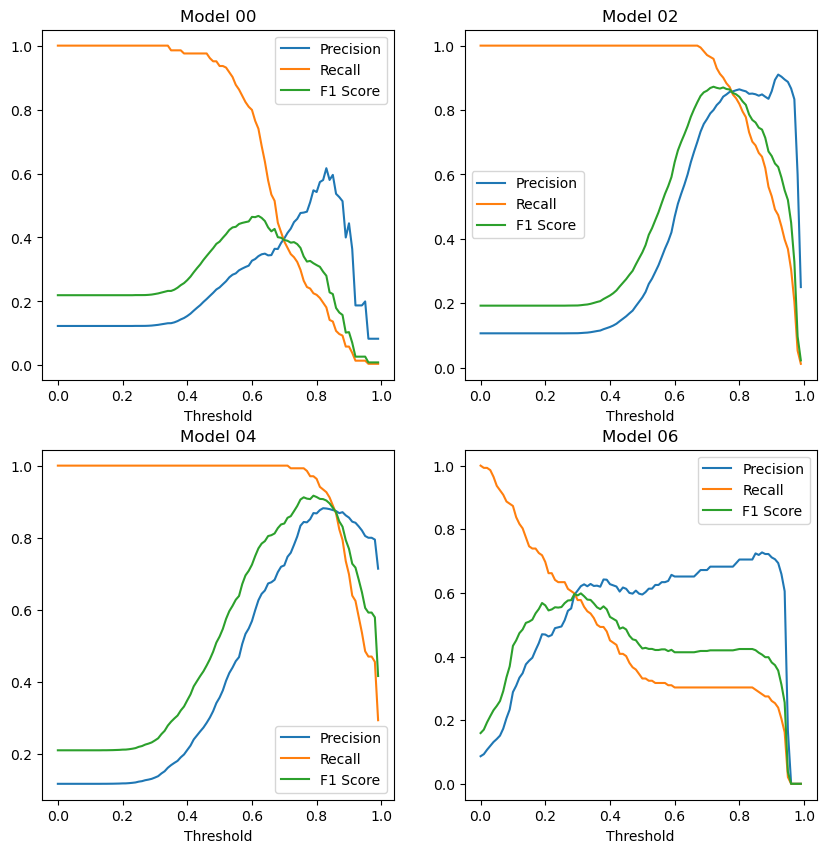

In [83]:
fig, subplots = plt.subplots(2, 2, figsize=(10, 10))

for index, id in enumerate(['00', '02', '04', '06']):
    ax = subplots[index // 2][index % 2]
    ax.plot(np.arange(0, 1, 0.01), list(precision[id].values()))
    ax.plot(np.arange(0, 1, 0.01), list(recall[id].values()))
    ax.plot(np.arange(0, 1, 0.01), list(f1_score[id].values()))
    ax.set_title(f'Model {id}')
    ax.set_xlabel('Threshold')
    ax.legend(['Precision', 'Recall', 'F1 Score'])
